# Lesson 3a: Multi-Label prediction with Planet Amazon dataset

In [15]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [16]:
from fastai.vision import *

In [ ]:
# ! {sys.executable} -m pip install kaggle --upgrade

In [2]:
# ! mkdir -p ~/.kaggle/
# ! mv kaggle.json ~/.kaggle/

# For Windows, uncomment these two commands
# ! mkdir %userprofile%\.kaggle
# ! move kaggle.json %userprofile%\.kaggle

In [17]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

WindowsPath('C:/Users/mdasco/.fastai/data/planet')

In [ ]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}

## Multi-classification
Contrary to the pets dataset studied in last lesson, here each picture can have multiple labels. If we take a look at the csv file containing the labels (in 'train_v2.csv' here) we see that each 'image_name' is associated to several tags separated by spaces.

In [18]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


### Data blocks

To put this in a DataBunch while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using ImageList (and not ImageDataBunch). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [19]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [20]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
      .split_by_rand_pct(0.2)
      .label_from_df(label_delim=' '))

In [21]:
data = (src.transform(tfms, size=128)
       .databunch().normalize(imagenet_stats))

`show_batch` still works, and show us the different labels separated by `;`.

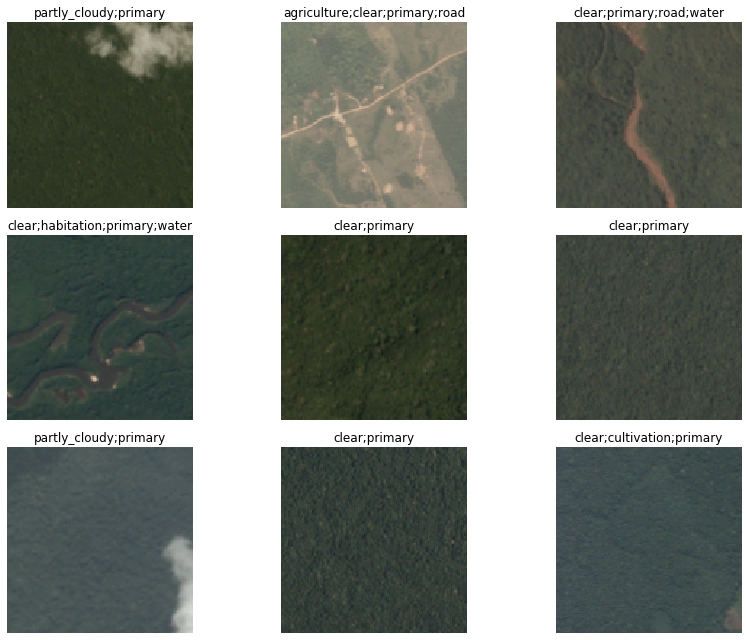

In [22]:
data.show_batch(rows=3, figsize=(12, 9))

To crate a `Learner` we use the same function as in lesson 1. Our base architecture is resnet50 again, but the metrics are a little bit differeent: we use `accuracy_thresh` instead of `accuracy`. In lesson 1, we determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. `accuracy_thresh` selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

As for Fbeta, it's the metric that was used by Kaggle on this competition. See [here](https://en.wikipedia.org/wiki/F1_score) for more details.

In [23]:
arch = models.resnet50

In [24]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

We us the LR Finder to pick a good learning rate.

In [25]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


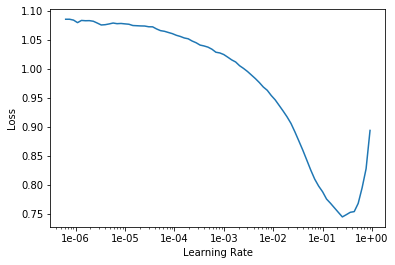

In [26]:
learn.recorder.plot()

Then we can fit the head of our network.

In [27]:
lr = 0.01

In [28]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.139390,0.119589,0.934157,0.882939,04:21
1,0.113054,0.097558,0.952607,0.915451,04:13
2,0.103654,0.092911,0.956335,0.920141,04:14
3,0.091691,0.089018,0.955579,0.922502,04:12
4,0.091529,0.087382,0.955216,0.924174,04:16


In [29]:
learn.save('stage-1-rn50')

..and fine-tune the whole model:

In [31]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


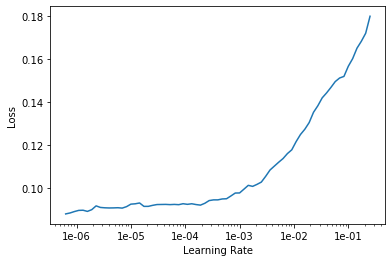

In [32]:
learn.lr_find()
learn.recorder.plot()

In [33]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.094623,0.090217,0.953857,0.921271,05:25
1,0.098190,0.090022,0.955375,0.923805,05:21
2,0.089903,0.087450,0.957229,0.924300,05:18
3,0.083913,0.083766,0.956400,0.927872,05:20
4,0.079732,0.083098,0.957614,0.928320,05:26


In [34]:
learn.save('stage-2-rn50')